# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. Модель должна иметь значение метрики *F1* не менее 0.75. 

**План проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`.
Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Предварительный-анализ-данных" data-toc-modified-id="Предварительный-анализ-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Предварительный анализ данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Создание-пайплайна" data-toc-modified-id="Создание-пайплайна-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Создание пайплайна</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
!pip install lightgbm -q

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter("ignore")

pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
LOCAL_PATH = './datasets/toxic_comments.csv'
REMOTE_PATH = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [3]:
if os.path.exists(LOCAL_PATH):
    toxic_comments = pd.read_csv(LOCAL_PATH)
elif os.path.exists(REMOTE_PATH):
    toxic_comments = pd.read_csv(REMOTE_PATH)
else:
    raise SystemError('Не удалось прочитать файл.')
    
toxic_comments.drop(columns='Unnamed: 0', inplace=True)

## Обзор данных

### Предварительный анализ данных

In [4]:
display(toxic_comments.head())
toxic_comments.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Всего в датасете 159292 записи и 2 столбца, пропусков не обнаружено. Проверим наличие дубликатов.

In [5]:
print(f'Количество дубликатов в датасете: {toxic_comments.duplicated().sum()}')

Количество дубликатов в датасете: 0


Дубликатов не обнаружено, проверим распределение целевого признака.

,toxic,percent
0,143106,89.8
1,16186,10.2


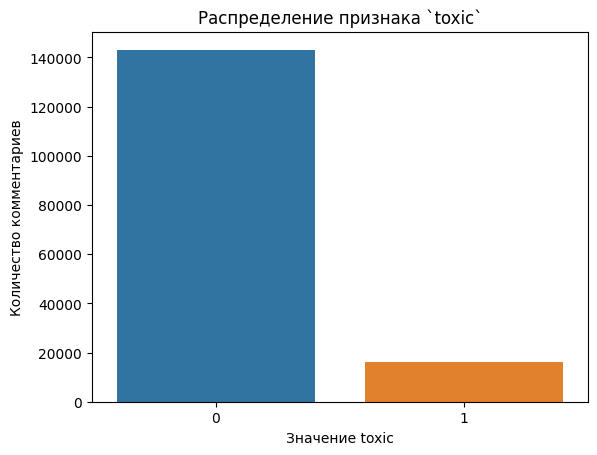

In [6]:
tox_table = pd.DataFrame(toxic_comments['toxic'].value_counts())
tox_table['percent'] = round(toxic_comments['toxic'].value_counts(normalize=True) * 100, 1)
display(tox_table)

tox_plot = sns.countplot(data=toxic_comments, x='toxic')
tox_plot.set(
        title=f'Распределение признака `toxic`',
        xlabel=f'Значение toxic',
        ylabel=f'Количество комментариев');

### Вывод



В ходе обзора данных были сделаны следующие выводы:
- Всего в датасете 159292 записи и 2 столбца;
- Пропусков не обнаружено;
- Дубликатов не обнаружено;
- Наблюдается дисбаланс классов, решим проблему с помощью стратификации на этапе разделения на выборки;
- Данные пригодны для исследования.

## Обучение моделей

### Лемматизация

In [7]:
m_lem = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stopwords = list(set(nltk_stopwords.words('english')))


# функция определение части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

# функция лемматизации и очистки текста
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([m_lem.lemmatize(word, get_wordnet_pos(word)) for word in word_list])
    lemm_text = re.sub(r'[^ a-zA-Z]', '', lemm_text)
    lemm_text = lemm_text.split()
    lemm_clear_text =  ' '.join(lemm_text)
    return lemm_clear_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\highs\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\highs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\highs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\highs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [8]:
# Проверим на тестовом предложении
sen_1 = 'When we were in Paris we visited a lot of museums. We first went to the Louvre, the largest art museum in the world. I have always been interested in art so I spent many hours there. The museum is enourmous, so a week there would not be enough.'

print(lemmatize(sen_1))

When we be in Paris we visit a lot of museum We first go to the Louvre the large art museum in the world I have always be interested in art so I spent many hour there The museum be enourmous so a week there would not be enough


In [9]:
tqdm.pandas()

toxic_comments['lem_text'] = toxic_comments['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
toxic_comments.head()

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,Daww He match this background colour I m seemi...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca nt make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


In [11]:
#toxic_comments.to_csv('./datasets/toxic_comments_lemm.csv')

Поскольку лемматизация заняла значительное время, было принято решение сохранить файл с лемматизированным текстом, чтобы можно было продолжить работу в будущем без повторной лемматизации.

In [12]:
toxic_comments = pd.read_csv('./datasets/toxic_comments_lemm.csv')
toxic_comments.head()

,Unnamed: 0,text,toxic,lem_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,Daww He match this background colour I m seemi...
2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca nt make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


Проверим лемматизированный текст на пропуски, чтобы не возникло проблем при обучении.

In [13]:
toxic_comments.isna().sum()

Unnamed: 0     0
text           0
toxic          0
lem_text      11
dtype: int64

In [14]:
toxic_comments.dropna(inplace=True)
toxic_comments.isna().sum()

Unnamed: 0    0
text          0
toxic         0
lem_text      0
dtype: int64

### Подготовка данных

In [15]:
X = toxic_comments['lem_text']
y = toxic_comments['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127424,)
(127424,)
(31857,)
(31857,)


### Создание пайплайна

In [16]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('models', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=RANDOM_STATE))])

pipeline

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['haven', "shan't", 'own', 're',
                                             'its', 'your', 'to', 'when', 'the',
                                             'about', 'ours', 'off', 'yours',
                                             'm', 'myself', 'has', 'in', 'some',
                                             'of', "hasn't", 'hers', 'not',
                                             'above', 'ma', "doesn't", 'don',
                                             'other', 'yourself', 'but',
                                             'shouldn', ...])),
                ('models',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [17]:
params = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': [0.1, 1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'models__class_weight': ['balanced', None]
    },
    
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__class_weight': ['balanced', None]
    },

    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__learning_rate': [0.01, 0.1, 0.5]
    }]

In [18]:
rand_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=params,
    scoring='f1',
    n_iter=5,
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1,
    error_score='raise')

rand_search

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['haven',
                                                                          "shan't",
                                                                          'own',
                                                                          're',
                                                                          'its',
                                                                          'your',
                                                                          'to',
                                                                          'when',
                                                                          'the',
                                                                          'about',
                                                                          'ours',
 

In [19]:
%%time

rand_search.fit(X_train, y_train)

CPU times: total: 15.2 s
Wall time: 12min 12s


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['haven',
                                                                          "shan't",
                                                                          'own',
                                                                          're',
                                                                          'its',
                                                                          'your',
                                                                          'to',
                                                                          'when',
                                                                          'the',
                                                                          'about',
                                                                          'ours',
 

In [20]:
print(f'Лучшая модель: {rand_search.best_params_}')
print(f'Значение метрики F1 для лучшей модели равно {round(rand_search.best_score_, 3)}')

Лучшая модель: {'models__penalty': 'l2', 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(C=10, random_state=42, solver='liblinear')}
Значение метрики F1 для лучшей модели равно 0.769


Видим, что значение метрики F1 для тренировочной выборки равно 0.769, что удовлетворяет условию заказчика. Проверим модель на тестовых данных.

### Тестирование модели

In [21]:
%%time

preds = rand_search.predict(X_test)

print(f'Значение метрики F1 на тестовых данных {round(f1_score(y_test, preds), 3)}')

Значение метрики F1 на тестовых данных 0.775
CPU times: total: 1.36 s
Wall time: 1.36 s


Для тестовой выборки модель тоже показала хороший результат, удовлетворяющий условию. Также заметно, что модель не переобучилась. Модель пригодна для дальнейшего применения.

### Вывод

В ходе обучения модели проделаны следующие работы:
- Проведена лемматизация исходных текстов;
- С помощью пайплайна проведена векторизация и выбор наилучшей модели машинного обучения;
- Наилучшие результаты показала модель логистической регрессии со следующими параметрами: {'models__penalty': 'l2', 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42, solver='liblinear');
- Значение метрики F1 для тренировочной выборки равно 0.769;
- Значение метрики F1 для тестовой выборки равно 0.775.

## Общий вывод

В ходе проведенного исследования был проделан следующий ряд работ и сделаны следующие выводы:


1. Открыт и изучен файл:

    - Всего в датасете 159292 записи и 2 столбца;
    - Пропусков не обнаружено;
    - Дубликатов не обнаружено;
    - Наблюдается дисбаланс классов, решим проблему с помощью стратификации на этапе разделения на выборки;
    - Данные были признаны пригодными для исследования.


2. Построены модели машинного обучения:

    - Проведена лемматизация исходных текстов;
    - С помощью пайплайна проведена векторизация и выбор наилучшей модели машинного обучения;
    - Наилучшие результаты показала модель логистической регрессии со следующими параметрами: {'models__penalty': 'l2', 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42, solver='liblinear');
    - Значение метрики F1 для тренировочной выборки равно 0.769;
    - Значение метрики F1 для тестовой выборки равно 0.775.


4. Итоговый вывод:

    - Полученная с помощью подбора гиперпараметров модель машинного обучения соответствует условию заказчика и может быть рекомендована для применения.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны